おいもりのカブデータセットを使って分類する<br>
とりあえず機械学習モデルで実装<br>

1.npy読み込み

In [0]:
import numpy as np

#フォルダへのディレクトリ
directory = ''

#データ
data = np.load(directory+'data/data.npy')
#ラベル
data_labels = np.load(directory+'data/data_labels.npy')

#欠損データ
nan = np.load(directory+'data/nan.npy')
#欠損データラベル
nan_labels = np.load(directory+'data/nan_labels.npy')

2.学習


In [0]:
# import libraries
import numpy as np
import pandas as pds

import matplotlib.pyplot as plt
#pair plot
import seaborn as sns

#--------------Preprocessing-------------------------------------
from sklearn.model_selection import train_test_split

#Standardization
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#PCA
from sklearn.decomposition import PCA

#--------------Learning Models-------------------------------------
#K-NN,Logistic
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#LinearSVC,kernelSVC
from sklearn.svm import LinearSVC, SVC

#DecisionTree
from sklearn.tree import DecisionTreeClassifier

#RandomForest,Gradient Boosting
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#交差検証(K-fold CrossVal) (未実装)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


#gridsearch CV(I found it after implementing CV process...)
from sklearn.model_selection import GridSearchCV

#----------------------------------------------------------
from sklearn.metrics import accuracy_score

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

#Decision Boundary viewer
%matplotlib inline
plt.style.use('ggplot')
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import itertools

#time function
import time 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#分割とシャッフル
train,test,tr_labels,te_labels = train_test_split(data,data_labels)

In [0]:
#model definition

def define_models():
  '''
  return
  models{0:model,1:name of model}
  '''
  models = []

  #K-NN
  grid_KNN = {'n_neighbors': [1,3,5,7,9]}
  model_KNN = KNeighborsClassifier()
  models.append((model_KNN,grid_KNN))

  #Logistic
  model_Logis = LogisticRegression(random_state=None)
  models.append((model_Logis,None))

  #Support Vector Classifier
  grid_LSVC = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
  model_LSVC = LinearSVC()
  models.append((model_LSVC,grid_LSVC))

  #SVC Applied Kernel Trick
  #it can select kernel(I couldn't apply....) 
  grid_SVC = {'C': [0.001, 0.01, 0.1, 1, 10, 100],  'gamma' : [0.001, 0.01, 0.1, 1, 10, 100]}
  model_SVC = SVC()
  models.append((model_SVC,grid_SVC))

  #DecisionTree
  grid_Dec = {'max_depth': [1,3,5,7,9]}
  model_Dec = DecisionTreeClassifier()
  models.append((model_Dec,grid_Dec))

  #RandomForest
  grid_RandomForest = {'max_depth': [1,3,5,7,9]}
  model_RandomForest = RandomForestClassifier()
  models.append((model_RandomForest,grid_RandomForest))

  #Gradient Boosting
  #If it applies 'exponential' loss,it works when is given only 2 classes.
  grid_GBC = {'loss':['deviance']}
  model_GBC =  GradientBoostingClassifier()
  models.append((model_GBC,grid_GBC))

  #CV params
  num_fold = 10
  models = np.array(models)
  #appling GridSearch and Cross Validation
  for model in models:
    name  = model[0].__class__.__name__
    if(model[1] is not None):
      model[0] = GridSearchCV(model[0],param_grid = model[1],scoring= "accuracy",cv = num_fold)
    model[1] = name
  return models

#learning method
def fit_models(models,X,Y):
  for model in models:
    start = time.time()
    model[0].fit(X,Y)
    spend = time.time()-start
    print(model[1],':finished(%.2f' % spend,'s)') 

In [0]:
#fitting
model = define_models()
fit_models(model,train,tr_labels)

KNeighborsClassifier :finished(0.13 s)
LogisticRegression :finished(0.02 s)
LinearSVC :finished(0.38 s)
SVC :finished(1.39 s)
DecisionTreeClassifier :finished(0.08 s)
RandomForestClassifier :finished(7.38 s)
GradientBoostingClassifier :finished(4.96 s)


In [0]:
#function calcurats accuracy 

from sklearn.metrics import confusion_matrix

def predict_models(models,X_test):
  Y_preds = []
  for model in models:
    Y_preds.append(model[0].predict(X_test))
  return Y_preds

def evaluate_models(models,X_test,Y_test,showimg = False,saveimg = False):
    accs = []
    confs = []
    for model,name in models:
      pred = model.predict(X_test)
      acc = accuracy_score(Y_test,pred)
      conf = confusion_matrix(Y_test, pred)
      accs.append(acc)
      print(name,': %.2f'% acc)

      #convert conf to percentage
      conf = conf.astype(np.float)
      for j in range(0,len(conf)):
        count = sum(conf[:,j])
        
        #for avoiding 0div
        if(count == 0):
          conf[:,j] = np.zeros(conf[:,j].shape)
        else:
          conf[:,j] = conf[:,j] * 100.00 / float(count)
      confs.append(conf)

    
    #show confusion matrix
    if(showimg):
      plot_heatmap(models[:,1],confs,saveimg)
    return accs


In [0]:
def plot_heatmap(models_name,confusions,saveimg):
    #create graph
    #2images each row
    dev = int((len(models_name)+len(models_name)%2)/2)
    gs = GridSpec(dev, 2)

    fig, axes = plt.subplots(nrows=dev, ncols= 2, figsize=(6*2,6*dev))
    for conf,name,grid in zip(confusions,models_name,
                         itertools.product(list(range(dev)),[0,1])
                         ):
      sns.heatmap(conf, annot=True, cmap='Blues',fmt='.2f',
                  ax = axes[grid],
                  xticklabels = True
                  )
      #print(axes[grid].__class__)
      axes[grid].set_title(name)

      if(saveimg):
        plt.savefig(directory+'confusion.png')

KNeighborsClassifier : 0.97
LogisticRegression : 0.90
LinearSVC : 0.94
SVC : 0.98
DecisionTreeClassifier : 0.99
RandomForestClassifier : 1.00
GradientBoostingClassifier : 1.00
----------------------------------
KNeighborsClassifier : 0.94
LogisticRegression : 0.81
LinearSVC : 0.89
SVC : 0.97
DecisionTreeClassifier : 0.93
RandomForestClassifier : 0.92
GradientBoostingClassifier : 0.97


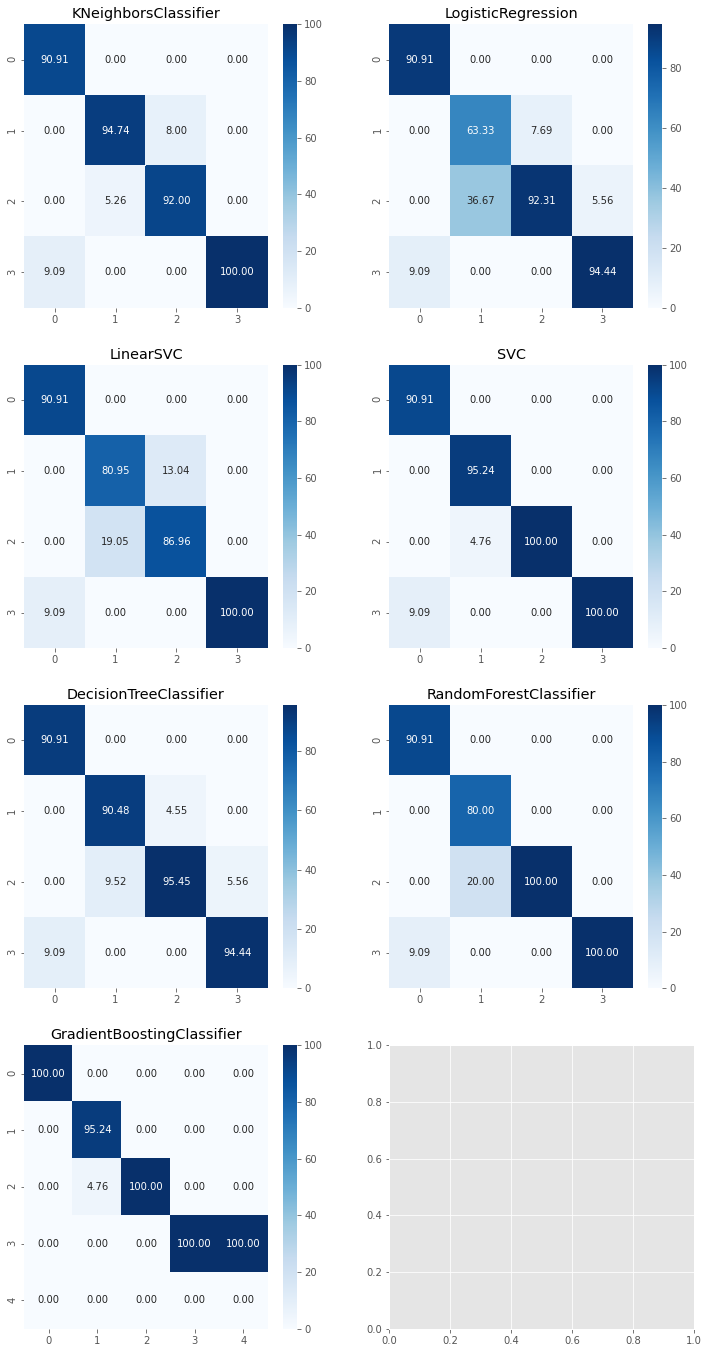

In [0]:
#acc using traindata
acc = evaluate_models(model,train,tr_labels)

print('----------------------------------')

#acc using testdata
acc = evaluate_models(model,test,te_labels,showimg=True,saveimg=True)

実際のデータで評価

In [0]:
from sklearn.externals import joblib

le = joblib.load(directory+'data/labelencoder.save') 

toy = np.array([47,98,119,153,156,136,68,65,62,58,54,50]).reshape(1,-1)
print(toy.shape)
toy_pred = predict_models(model,toy)

res = le.inverse_transform(toy_pred)
print('true:じりびんふぃーばー４')
for i in zip(model[:,1],res):
  print(i)

(1, 12)
true:つうじょうふぃーばー４
('KNeighborsClassifier', 'じりびんふぃーばー４')
('LogisticRegression', 'じりびんふぃーばー４')
('LinearSVC', 'じりびんふぃーばー４')
('SVC', 'じりびんふぃーばー３')
('DecisionTreeClassifier', 'つうじょう')
('RandomForestClassifier', 'つうじょう')
('GradientBoostingClassifier', 'つうじょう')
